## SMS SPAM DETECTION PROJECT

![Alt Text](wordss.jpg)

### 📖 Project Overview

The SMS Spam Detection project focuses on developing a machine learning model to classify text messages as either "ham" (non-spam) or "spam." In this project, we leverage various machine learning models such as Naive Bayes, Random Forest, and Decision Tree to build a classifier that can accurately identify spam messages. The project involves data preprocessing, feature extraction using CountVectorizer, and model evaluation using key metrics such as accuracy, precision, recall, F1 score, and ROC-AUC. The final objective is to deploy a reliable model that can effectively detect spam messages in real-world applications.

####

### 📊 Dataset Features
The dataset used for this project is the SMS Spam Collection Dataset, which contains a collection of text messages classified as either "ham" (non-spam) or "spam." The dataset consists of the following key columns:

#### label:

This is the target variable of the dataset. It indicates whether a message is "ham" (non-spam) or "spam" (spam).

#### Values: ham, spam

#### message:

This column contains the actual text of the SMS message. It includes a variety of messages ranging from personal conversations to promotional content.

#### Values: Text data

####

### 🎯 Goal of the Project
The main goal of this project is to build a machine learning model that can accurately predict whether a given SMS message is spam or not. Specifically, the objectives include:

#### Data Preprocessing: 
Cleaning and preparing the text data for model training, including removing unwanted characters and applying text normalization techniques such as stemming and lemmatization.

#### Feature Extraction: 
Converting text messages into numerical features using CountVectorizer to capture the frequency of words and phrases in the messages.

#### Model Training: 
Building and training various machine learning models, including Naive Bayes, Random Forest, and Decision Tree, and evaluating their performance.

#### Model Evaluation: 
Using key performance metrics such as accuracy, precision, recall, F1 score, and ROC-AUC to assess how well the models can classify SMS messages correctly, especially in terms of minimizing false positives and false negatives.

#### Deployment: 
After evaluating the models, the final model is serialized and saved for future use in practical spam detection applications.

The end goal is to create a robust spam filter that can be deployed in real-world messaging systems to automatically classify and filter out unwanted spam messages.

####

#### Imports and Setup 

In [168]:
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from imblearn.under_sampling import RandomUnderSampler
from wordcloud import WordCloud

import pickle


#### 

### Loading our  Data

In [171]:

# Loading and Dataset preprocessing


data = pd.read_csv("SMSSpamCollection", sep="\t", names=["label", "message"])
print(data.shape)
print(data.isnull().sum())
print(data['label'].value_counts())


(5572, 2)
label      0
message    0
dtype: int64
label
ham     4825
spam     747
Name: count, dtype: int64


####

### Class Distribution

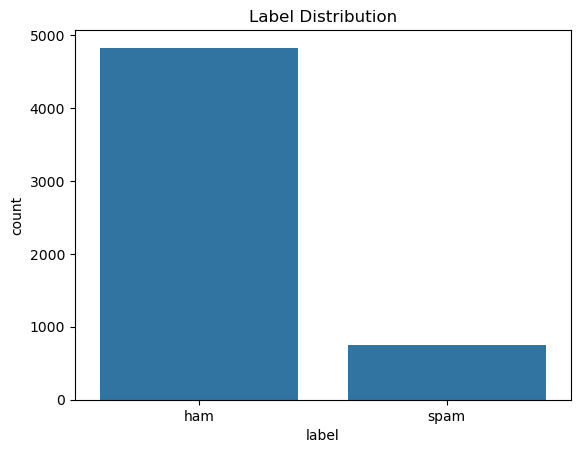

In [174]:
sns.countplot(x=data['label'])
plt.title("Label Distribution")
plt.show()


### 📊 Visualizing Class Distribution
The dataset consists of 5,572 messages with no missing values. The target variable, label, is imbalanced, with 4,825 "ham" (non-spam) messages and 747 "spam" messages. This imbalance is later addressed through techniques like Random Under-sampling to ensure fair model training.

####

### Text Preprocessing Function

In [178]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub("[^a-zA-Z]", " ", text).lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

data['lemmatized'] = data['message'].apply(preprocess_text)


### 🧹 Text Processing
The text processing function performs several key steps to prepare the SMS messages for model training:

#### Removing Non-Alphabetical Characters: 
It removes any characters that are not letters (such as numbers and punctuation) to focus on the core words in the message.

#### Lowercasing: 
The text is converted to lowercase to ensure consistency and avoid treating the same word in different cases (e.g., "Hello" and "hello") as distinct.

#### Tokenization: 
The text is split into individual words (tokens), which allows the model to analyze each word separately.

#### Removing Stopwords: 
Commonly used words (e.g., "and," "the," "is") that don't contribute meaningful information are removed.

#### Lemmatization: 
Each word is reduced to its base form (e.g., "running" becomes "run"). This ensures that variations of a word are treated as the same.

####

### Most Common Words in Spam Messages and Their Frequencies

      Word  Frequency
0     call        388
1     free        228
2        u        195
3        p        180
4      txt        170
5     text        145
6       ur        144
7   mobile        142
8     stop        128
9    claim        115
10       c        107
11   reply        106
12     www         98
13   prize         97
14     min         90
15    tone         90
16     get         86
17      uk         77
18    cash         76
19     win         73


<Figure size 1000x600 with 0 Axes>

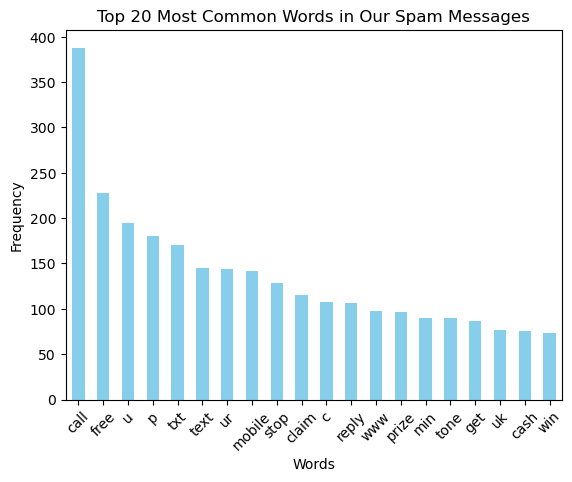

In [182]:
from collections import Counter
import matplotlib.pyplot as plt

# Filtered the dataset for spam messages
spam_messages = data[data['label'] == 'spam']['lemmatized']

# Combined all spam messages into one large string
spam_text = ' '.join(spam_messages)

# Splits the text into individual words
spam_words = spam_text.split()

# To Get the frequency of each word
word_counts = Counter(spam_words)

# To Get the 20 most common words and how often they appear
common_words = word_counts.most_common(20)

# DataFrame for better visualization
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Display the most common words
print(common_words_df)

# Plot a bar chart for the top 20 common words
plt.figure(figsize=(10, 6))
common_words_df.plot(kind='bar', x='Word', y='Frequency', legend=False, color='skyblue')
plt.title('Top 20 Most Common Words in Our Spam Messages')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


####

### Word Cloud Visualization

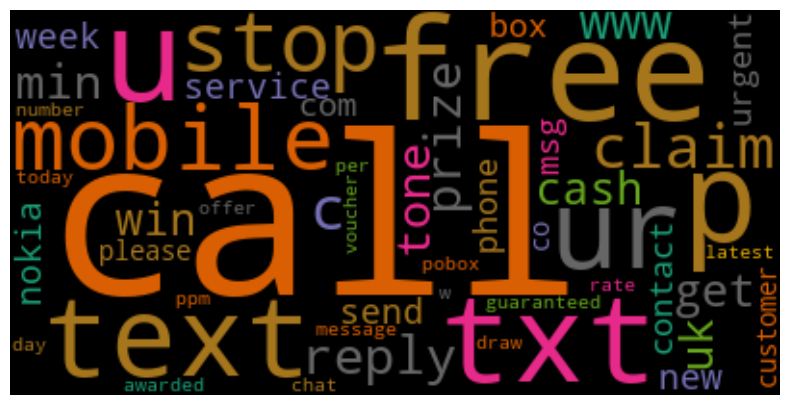

In [185]:
spam_words = " ".join(data[data['label'] == 'spam']['lemmatized'])
spam_freq = nltk.FreqDist(spam_words.split())

plt.figure(figsize=(10, 5))
wc = WordCloud(colormap="Dark2", max_words=50).generate_from_frequencies(spam_freq)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


####

### 📊 Feature Extraction & Label Encoding
In this step, we convert the cleaned text data into numerical form using CountVectorizer, which transforms each message into a vector of word counts. This allows the machine learning models to understand and learn from the text.

We also encode the target labels (ham and spam) into binary values (0 for ham, 1 for spam) to make them suitable for classification tasks.

In [188]:
cv = CountVectorizer(max_features=2500)
X = cv.fit_transform(data['lemmatized']).toarray()
y = data['label'].map({'ham': 0, 'spam': 1})


####

###  ⚖️ Handling Class Imbalance
Since the dataset has significantly more ham messages than spam, we apply Random Under Sampling to balance the classes. This helps prevent the model from being biased toward the majority class and improves its ability to detect spam effectively.

In [191]:
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)
print("Resampled class distribution:", pd.Series(y_resampled).value_counts())


Resampled class distribution: label
0    747
1    747
Name: count, dtype: int64


####

### Train-Test Split

In [194]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


####

### Training & Comparing Models

####

### 🤖 Model Training & Evaluation Function
This function automates training, prediction, and evaluation of each model. It displays key performance metrics (accuracy, precision, recall, F1 score), along with a confusion matrix and ROC curve to visually assess how well the model distinguishes between spam and ham messages.

In [199]:
from sklearn.metrics import classification_report 

def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    
    # Get predictions and probabilities
    prediction = model.predict(X_test)
    prediction_proba = model.predict_proba(X_test)[:, 1]  
    
    # Calculate metrics
    acc = accuracy_score(y_test, prediction) * 100
    prec = precision_score(y_test, prediction) * 100
    rec = recall_score(y_test, prediction) * 100
    f1 = f1_score(y_test, prediction) * 100
    auc = roc_auc_score(y_test, prediction_proba)  

    # Display model performance metrics
    print(f"\n{name} Performance:")
    print(f"Accuracy: {acc:.2f}%")
    print(f"Precision: {prec:.2f}%")
    print(f"Recall: {rec:.2f}%")
    print(f"F1 Score: {f1:.2f}%")
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, prediction)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Pastel1_r", xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, prediction_proba)  
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})", color='b', lw=2)
    plt.plot([0, 1], [0, 1], 'r--', label="Random Classifier (AUC = 0.5)") 
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Classification Report
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, prediction, target_names=["Ham", "Spam"]))
    
    return prec  


####

### Naive Bayes Classifier


Naive Bayes Performance:
Accuracy: 95.99%
Precision: 96.71%
Recall: 95.45%
F1 Score: 96.08%


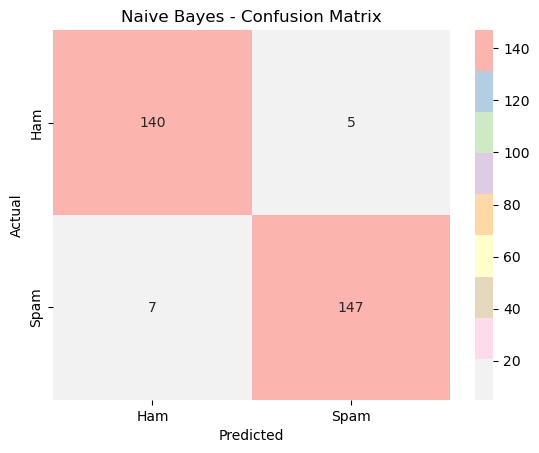

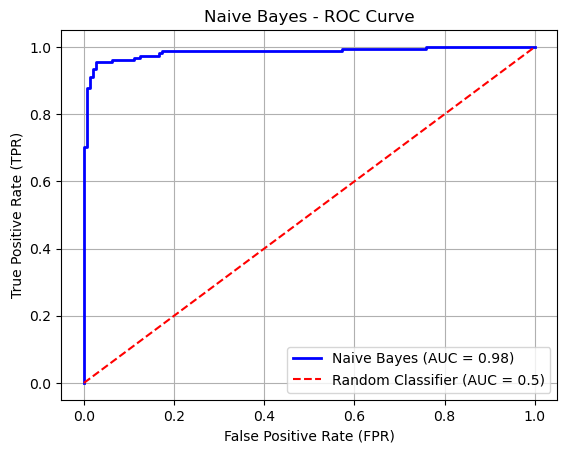


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         Ham       0.95      0.97      0.96       145
        Spam       0.97      0.95      0.96       154

    accuracy                           0.96       299
   macro avg       0.96      0.96      0.96       299
weighted avg       0.96      0.96      0.96       299



In [202]:
nb_model = MultinomialNB()
nb_precision = evaluate_model(nb_model, X_train, X_test, y_train, y_test, "Naive Bayes")


####

### Random Forest Classifier


Random Forest Performance:
Accuracy: 92.98%
Precision: 96.50%
Recall: 89.61%
F1 Score: 92.93%


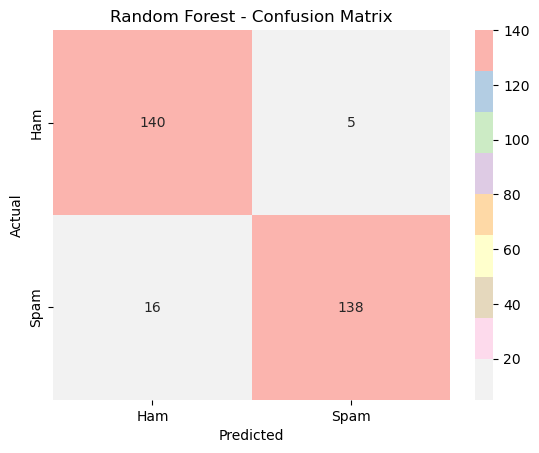

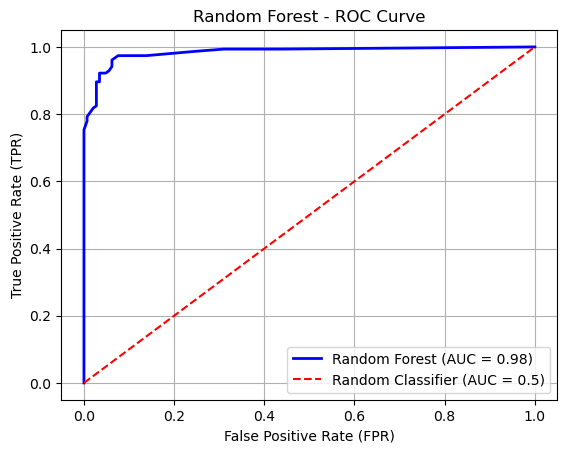


Random Forest Classification Report:
              precision    recall  f1-score   support

         Ham       0.90      0.97      0.93       145
        Spam       0.97      0.90      0.93       154

    accuracy                           0.93       299
   macro avg       0.93      0.93      0.93       299
weighted avg       0.93      0.93      0.93       299



In [205]:
rf_model = RandomForestClassifier(n_estimators=30, random_state=42)
rf_precision = evaluate_model(rf_model, X_train, X_test, y_train, y_test, "Random Forest")


####

### Decision Tree Classifier


Decision Tree Performance:
Accuracy: 90.64%
Precision: 93.75%
Recall: 87.66%
F1 Score: 90.60%


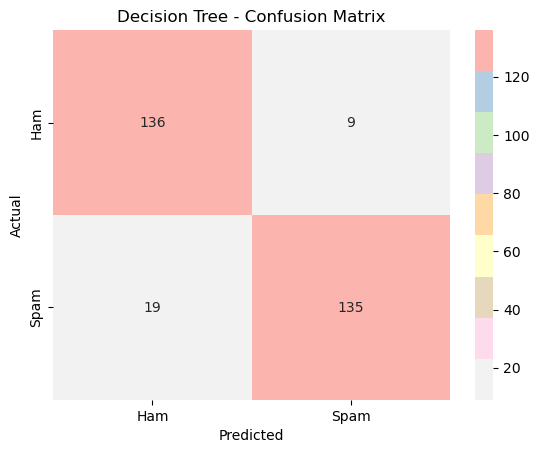

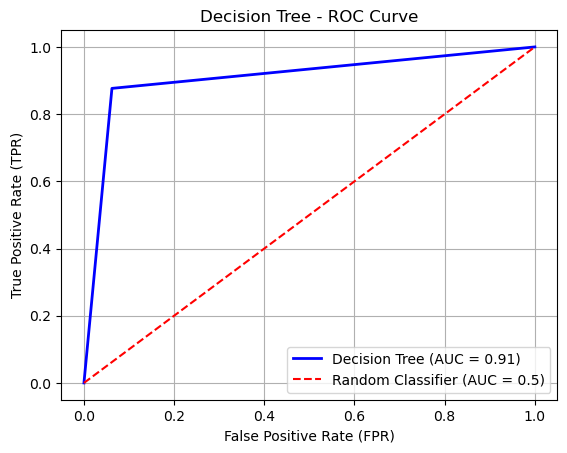


Decision Tree Classification Report:
              precision    recall  f1-score   support

         Ham       0.88      0.94      0.91       145
        Spam       0.94      0.88      0.91       154

    accuracy                           0.91       299
   macro avg       0.91      0.91      0.91       299
weighted avg       0.91      0.91      0.91       299



In [208]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_precision = evaluate_model(dt_model, X_train, X_test, y_train, y_test, "Decision Tree")


####

### Model Comparison

In [211]:

# Comparison Table

comparison_data = {
    "Model": ["Naive Bayes", "Random Forest", "Decision Tree"],
    "Precision (%)": [nb_precision, rf_precision, dt_precision]
}

comparison_df = pd.DataFrame(comparison_data)


print(comparison_df)

           Model  Precision (%)
0    Naive Bayes      96.710526
1  Random Forest      96.503497
2  Decision Tree      93.750000


####

### Serialize the Best Model

In [214]:
with open('model_v2.pkl', 'wb') as f:
    pickle.dump(nb_model, f)

with open('cv_transform_v2.pkl', 'wb') as f:
    pickle.dump(cv, f)

print("✅ Model and vectorizer saved as 'model_v2.pkl' and 'cv_transform_v2.pkl'")


✅ Model and vectorizer saved as 'model_v2.pkl' and 'cv_transform_v2.pkl'


####

####

### TEST - Tkinter app

### ✉️ Example Messages to Try

"Congratulations! You've won a $1000 Walmart gift card. Click here to claim your prize now!"

Expected Output: 🚨 SPAM

"Hey, are we still meeting for lunch tomorrow?"

Expected Output: ✅ HAM

"URGENT! Your account has been compromised. Send your login details to secure it."

Expected Output: 🚨 SPAM

"Don’t forget to bring the documents to the office meeting."

Expected Output: ✅ HAM

"You have been selected for a free vacation to the Bahamas! Call now!"

Expected Output: 🚨 SPAM

In [ ]:
import tkinter as tk
from tkinter import messagebox
import pickle

# Load model and vectorizer
model = pickle.load(open("model_v2.pkl", "rb"))
vectorizer = pickle.load(open("cv_transform_v2.pkl", "rb"))

# Prediction function
def predict_spam():
    message = text_input.get("1.0", tk.END).strip()
    if not message:
        messagebox.showwarning("Input Error", "Please enter a message.")
        return
    vectorized = vectorizer.transform([message])
    result = model.predict(vectorized)
    output = "⚠️ SPAM Message Detected!" if result[0] == 1 else "✅ This is a Legitimate Message."
    result_label.config(text=output, fg="red" if result[0] == 1 else "green")

# Initialize GUI window
root = tk.Tk()
root.title("📱 SMS Spam Detector")
root.geometry("500x350")
root.configure(bg="#f0f4f7")

# Title
tk.Label(root, text="📩 SMS Spam Detection", font=("Helvetica", 18, "bold"), bg="#f0f4f7", fg="#333").pack(pady=10)

# Instruction
tk.Label(root, text="Enter the message below to check if it's spam or not:", font=("Helvetica", 11), bg="#f0f4f7").pack(pady=5)

# Text Input
text_input = tk.Text(root, height=5, width=50, font=("Helvetica", 11))
text_input.pack(pady=10)

# Predict Button
tk.Button(root, text="🔍 Detect Spam", font=("Helvetica", 12, "bold"), bg="#007acc", fg="white", padx=20, pady=5, command=predict_spam).pack(pady=10)

# Result Label
result_label = tk.Label(root, text="", font=("Helvetica", 13, "bold"), bg="#f0f4f7")
result_label.pack(pady=10)

# Run App
root.mainloop()
